## 1. Data Loading & Preprocessing

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA

# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets on CustomerID
df = pd.merge(transactions, customers, on='CustomerID', how='left')

# Convert dates
df['SignupDate'] = pd.to_datetime(df['SignupDate'])
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
latest_date = df['TransactionDate'].max()

# Feature engineering: RFM + Tenure
rfm = df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (latest_date - x.max()).days,  # Recency
    'TransactionID': 'count',                                    # Frequency
    'TotalValue': 'sum'                                          # Monetary
}).rename(columns={
    'TransactionDate': 'Recency',
    'TransactionID': 'Frequency',
    'TotalValue': 'Monetary'
})

tenure = df.groupby('CustomerID')['SignupDate'].min().reset_index()
tenure['Tenure'] = (latest_date - tenure['SignupDate']).dt.days
tenure.drop('SignupDate', axis=1, inplace=True)

# Merge RFM and Tenure
features = pd.merge(rfm, tenure, on='CustomerID', how='left')

# One-hot encode Region
features = pd.merge(features, customers[['CustomerID', 'Region']], on='CustomerID', how='left')
features = pd.get_dummies(features, columns=['Region'], prefix='Region')

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.drop('CustomerID', axis=1))

##  Determine Optimal Clusters

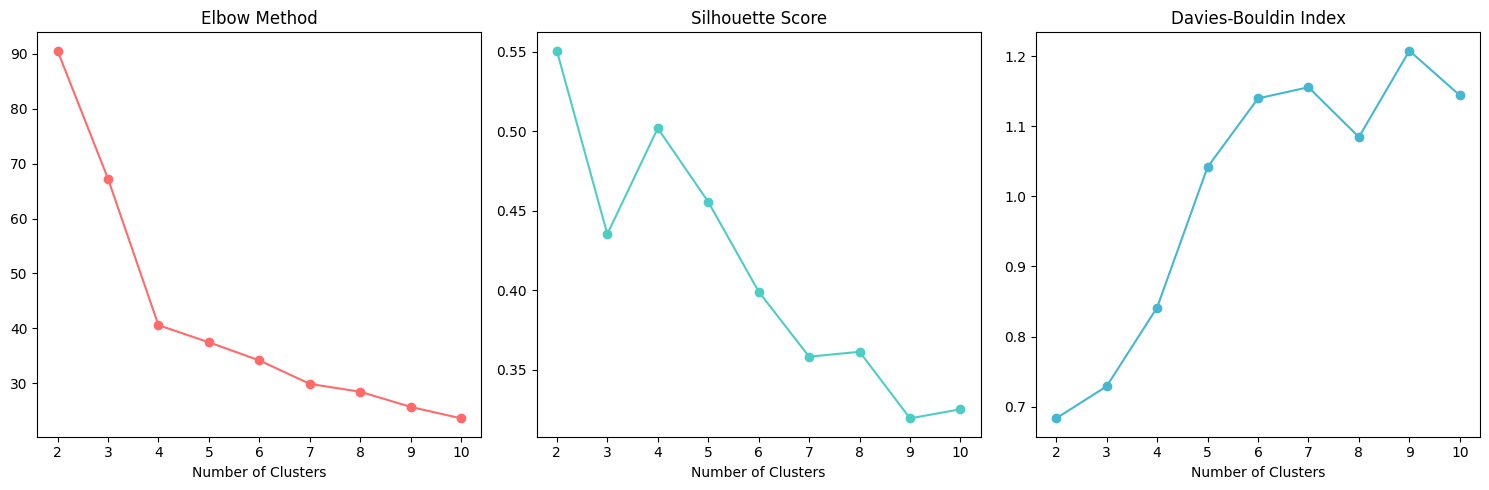

In [53]:
# Elbow Method & Silhouette Analysis
inertia = []
silhouette = []
db_index = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled_features, clusters))
    db_index.append(davies_bouldin_score(scaled_features, clusters))

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(k_range, inertia, marker='o', color='#FF6B6B')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')

plt.subplot(1, 3, 2)
plt.plot(k_range, silhouette, marker='o', color='#4ECDC4')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')

plt.subplot(1, 3, 3)
plt.plot(k_range, db_index, marker='o', color='#45B7D1')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of Clusters')

plt.tight_layout()
plt.show()

## Train Final Model

In [54]:
# Train with optimal k (example: k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)

# Add clusters to features
features['Cluster'] = clusters

In [56]:

# Calculate final metrics
final_db_index = davies_bouldin_score(scaled_features, clusters)
print(f"Final Davies-Bouldin Index: {final_db_index:.2f}")

# Calculate Silhouette Score
silhouette_avg = silhouette_score(scaled_features, clusters)
print(f"Final Silhouette Score: {silhouette_avg:.2f}")

Final Davies-Bouldin Index: 0.84
Final Silhouette Score: 0.50


# Cluster Visualization


## A. PCA 2D Plot

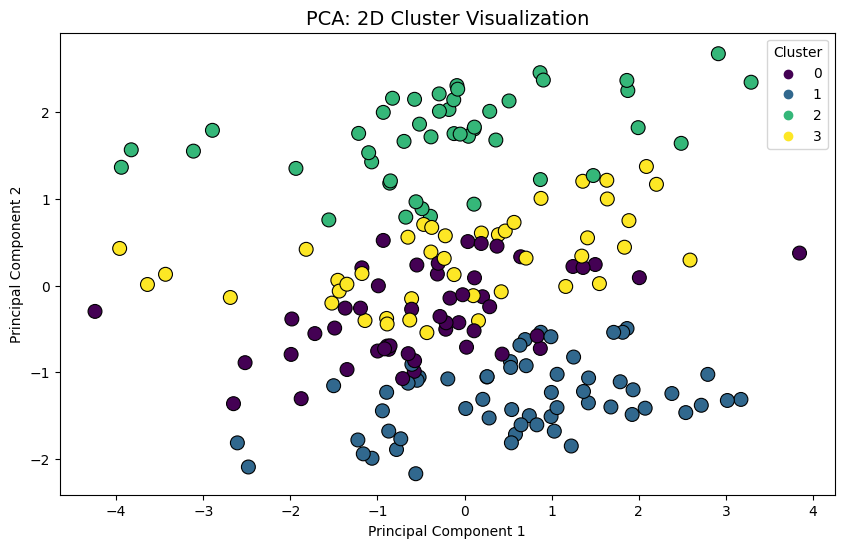

In [47]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_result[:, 0], 
    y=pca_result[:, 1], 
    hue=features['Cluster'], 
    palette='viridis',
    s=100,
    edgecolor='k'
)
plt.title('PCA: 2D Cluster Visualization', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

## B. Cluster Profile Radar Chart

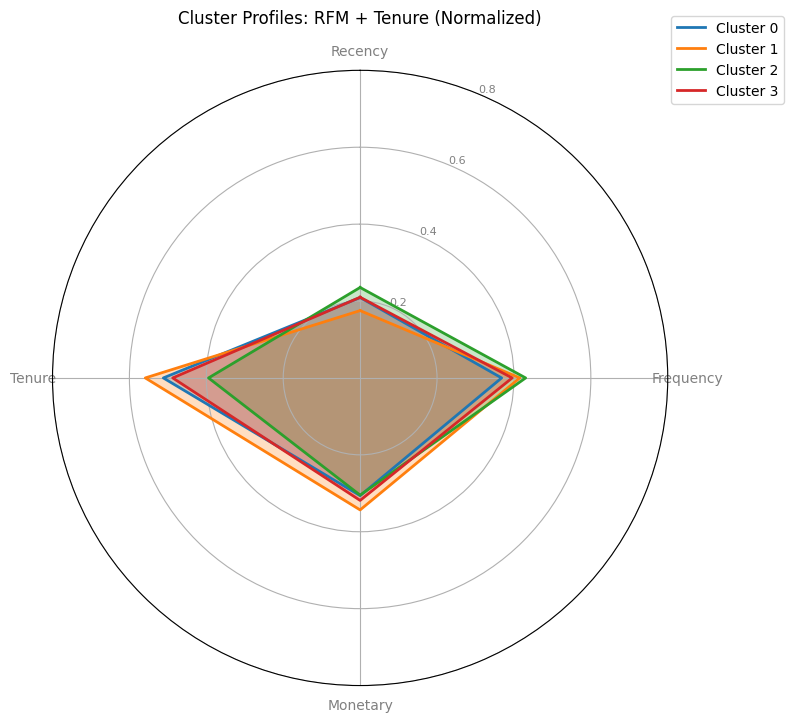

In [48]:
# Select and scale the features
features_to_scale = ['Recency', 'Frequency', 'Monetary', 'Tenure']
scaler = MinMaxScaler()

# Create a copy of the numeric features and scale them
scaled_features = features[features_to_scale].copy()
scaled_features[features_to_scale] = scaler.fit_transform(scaled_features)
scaled_features['Cluster'] = features['Cluster']

# Calculate cluster means with scaled features
cluster_means = scaled_features.groupby('Cluster').mean().reset_index()

# Plot radar chart with scaled values
categories = features_to_scale
N = len(categories)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Reduced figure size from (10,10) to (6,6)
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

for i, cluster in enumerate(cluster_means['Cluster']):
    values = cluster_means.loc[cluster_means['Cluster'] == cluster, categories].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.25)

plt.xticks(angles[:-1], categories, color='grey', size=10)  # Reduced font size
plt.yticks([0.2, 0.4, 0.6, 0.8], ['0.2', '0.4', '0.6', '0.8'], color='grey', size=8)  # Reduced font size
plt.title('Cluster Profiles: RFM + Tenure (Normalized)', pad=15, fontsize=12)  # Reduced title size and padding
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))  # Adjusted legend position
plt.tight_layout()
plt.show()

## 1. Bar plot showing cluster sizes

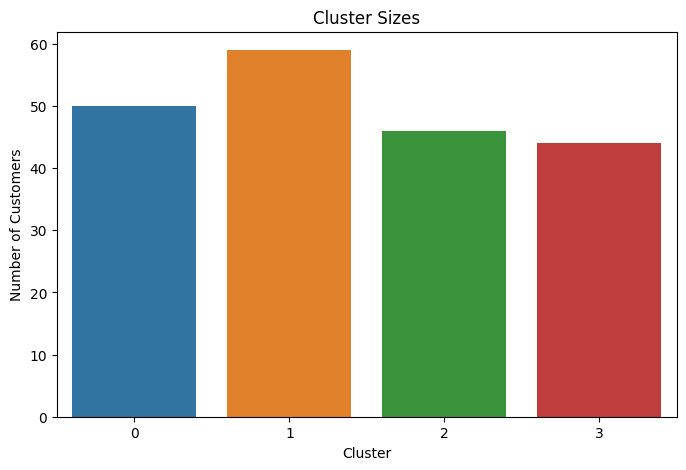

In [49]:

plt.figure(figsize=(8, 5))
cluster_sizes = features['Cluster'].value_counts().sort_index()
sns.barplot(x=cluster_sizes.index, y=cluster_sizes.values)
plt.title('Cluster Sizes')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

## 2. Box plots for each feature across clusters

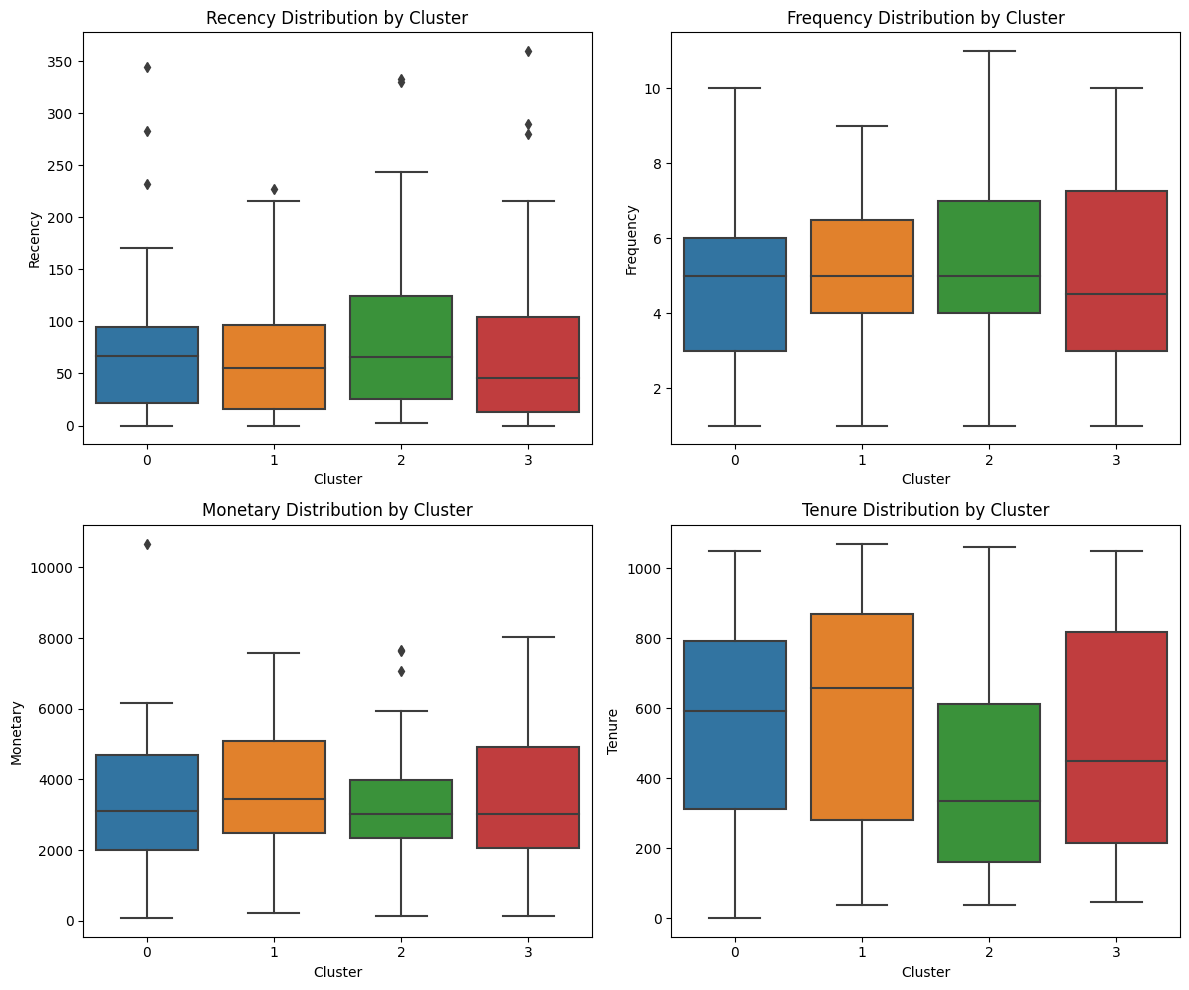

In [50]:

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
features_to_plot = ['Recency', 'Frequency', 'Monetary', 'Tenure']

for i, feature in enumerate(features_to_plot):
    ax = axes[i//2, i%2]
    sns.boxplot(data=features, x='Cluster', y=feature, ax=ax)
    ax.set_title(f'{feature} Distribution by Cluster')

plt.tight_layout()
plt.show()

## 3. Violin plots to show distribution density

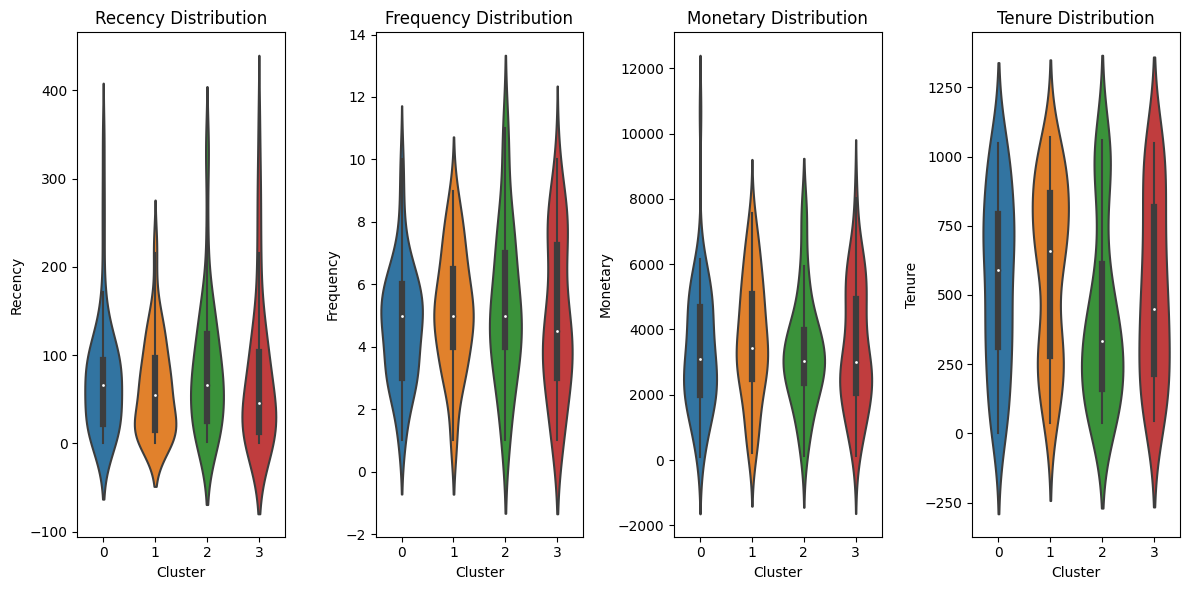

In [51]:

plt.figure(figsize=(12, 6))
for i, feature in enumerate(features_to_plot):
    plt.subplot(1, 4, i+1)
    sns.violinplot(data=features, x='Cluster', y=feature)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

## 6. Heatmap of cluster centers

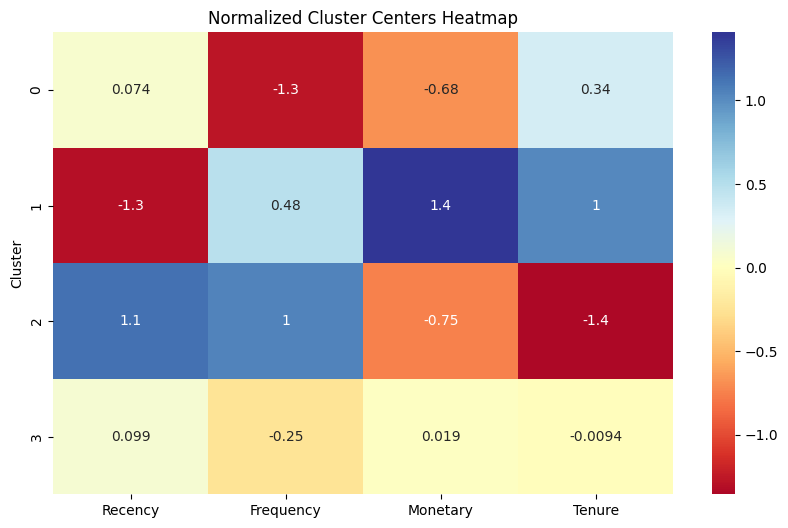

In [52]:

cluster_centers = features.groupby('Cluster')[features_to_plot].mean()
# Normalize cluster centers for better visualization
cluster_centers_norm = (cluster_centers - cluster_centers.mean()) / cluster_centers.std()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_centers_norm, annot=True, cmap='RdYlBu', center=0,xticklabels=1)
plt.title('Normalized Cluster Centers Heatmap')
plt.show()